
  This computing assignment involved analysis of the 2009-2013 US Census American Community Survey, which contains information on about 1% of the total US population. Needless to say, a true case of "big data"-- 600MB compressed and over 5GB un-compressed. Data were read-in and analysed in R 3.2.3 ("Wooden Christmas-Tree"), and written up in Jupyter Notebook employing IRkernel. This report required a great deal of trial and error-- tens of hours worth-- but it was highly educational. I began by reading in the **full**, compressed dataset using read.csv( ), scan( ), and readLines( ) -- process that took between 25-60 minutes each, and left my computer completely useless in the meantime-- and then, separately, subsetting by the 14 columns of interest and randomly selecting 1 million rows. Fortunately, Wilson was kind enough to lend some useful hints on the "divide-and-conquer" strategy. This is where my write-up begins.

# Data Read-In
## General approach
1. Describe the compressed file ('.csv.bz2' extension).

2. Create an index that will allow random slection of 1 million rows from the raw file.

3. Read in the compressed file ('.csv.bz2' extension) into R 1% at a time. On each 1% chunk, subset by the 14 columns of interest (out of the total 205).</p>

4. From each 1% chunk, keep only those rows included in the random sample of 1 million. </p>

## Describing a compressed data file
An understanding of the total number of rows in the uncompressed file was required in order to evenly split it into 1% chunks. A number of methods exist for doing this, but, because the file was of a relatively mangeable size, I chose to use the bzcat and wc expressions in Unix:

In [1]:
suppressWarnings(suppressMessages(library(data.table)))
suppressWarnings(suppressMessages(library(plyr)))
suppressWarnings(suppressMessages(library(ff)))
suppressWarnings(suppressMessages(library(ggplot2)))
suppressWarnings(suppressMessages(library(biglm)))

In [2]:
# system("bzcat ss13hus.csv.bz2 | wc -l")

# Store the ouutput for later use
row_num_total <- 7219000

Curious to know more about the dataset's column names and types, I read in the first few lines of the compressed file-- this would help me in the column-subsetting process later.

In [3]:
# Define target file
targetfile <- 'ss13hus.csv.bz2'

# Read first few rows and get col number
header <- read.csv(targetfile, nrows=100, header=T, sep=',')
paste("# of Rows:",length(colnames(header)))

# Define columns of interest
col_list <- c('REGION', 'ST', 'ADJHSG', 'ADJINC', 'NP', 'ACR','BDSP',
                  'ELEP', 'GASP', 'RMSP', 'VEH', 'WATP', 'FINCP', 'HINCP')

# Index columns of interest
paste("Columns of interest:",list(which(colnames(header) %in% col_list)))

[1] "# of Rows: 205"

[1] "Columns of interest: c(7, 8, 9, 10, 12, 14, 17, 21, 24, 32, 45, 46, 49, 55)"


I then created a vector to be used in 'col_clases' to select only for the 14 columns of interest when reading in data via read.csv or scan. In these functions, the 'colClasses' argument can be used to leave some columns unread (i.e. any marked "NULL"). I will also use this vector to specify the class of the 14 variables of interest, so that the computer doesn't have to spend time guessing.

In [4]:
#str(header)
class_vec <- c(rep("NULL",6),rep('numeric',4),"NULL",'numeric',"NULL",
                'numeric',rep("NULL",2),'numeric',rep("NULL",3),
                'numeric',rep("NULL",2),'numeric',rep("NULL",7),
                'numeric',rep("NULL",12),rep('numeric',2),rep("NULL",2),
                'numeric',rep("NULL",5),'numeric',rep("NULL",150))

#confirm length
#count(class_vec)

## Create an index-vector for randomly selecting 1,000,000 rows
The next step was to prepare a vector of 1 million random rows from the 7,219,000 total rows in the uncompressed target file. For future reproducibility, a seed was set at 1000. (Note: I create and store store the vector in data table format for future use in merging, etc.)

In [5]:
samp_size <- 1000000 
set.seed(1000)
samp <- as.data.table(sample(7219000, samp_size, replace = FALSE))
samp <- rename(samp,c('V1'='row'))

# Final, sorted vector of randomly-selected indices
subset <- sort(as.numeric(samp$row))

## Data read-in

To do this, I first created an architechture for breaking the file up into 100 manageable chunks to be read in and modified sequentially. This would keep memory use to a moderately low level (< 1gb) and, thus, prevent any major melt downs.

In [6]:
index <- 0
chunksize <- row_num_total/100
number_of_chunks_to_do <- 100

### read.csv( )
I then set about reading the data in, one chunk at a time, subsetting by the 14 columns of interest, and then, from each chunk, saving only those rows specified in the random-sample index vector to .csv. For speediness and to avoid reading the entire data file into memory each iteration, I employed the "connection" technique of intermittently accessing files. I attempted this general approach using the three pre-specified packes: read.csv, scan, and readLines.

First up was read.csv. This package is in the read.table family, and, just as it sounds, is very good for reading data stored in tabular form (e.g. a comma delimted Excel file) into memory in the form of a data frame. Here is how I set about looping though data chunks with read.csv.

In [7]:
con <- file(description=targetfile,"r")

system.time(
repeat {
        index <- index + 1
        #print(paste('Processing rows:', index * chunksize))
        #print(paste('iteration #',index,sep=" "))

        # stop/break after 100 chunks 
        if (index > number_of_chunks_to_do){
                print('Processed all files!')
                break}
        
        else {
        	# if first chunk, header=T and append = F
        	if (index==1){

        		# read the 14 columns of interst into memory, '
                # chunksize' # of rows at a time
		        dataChunk <- read.csv(con, nrows=chunksize, header = T, 
                                      skip=0, colClasses=class_vec, 
                                      sep=",")

		        # write to CSV only those rows that correspond to our 
                # random subset, keeping column names
		        write.csv(dataChunk[rownames(dataChunk) %in% subset,],
                          'csv/dataChunk.csv', row.names=F)

		        # print to keep a record of activity
		        # print(head(dataChunk,5))
            }

		    # if 2nd chunk or later, header = F and append = T
			else {
				    # read the 14 columns of interst into memory, 
                    #'chunksize' # of rows at a time
			        dataChunk <- read.csv(con, nrows=chunksize, 
                                        header = F, skip=0, colClasses=
                                          class_vec, sep=",")

				    # append to the original CSV (chunk # 1) only those 
                    # rows that correspond to our random subset
		         	# because rowname restarts every iteration, 
                    # add chunksize*index-1
			        write.csv(dataChunk[(as.numeric(rownames(dataChunk)) +
                            (chunksize*(index-1))) %in% subset,],
                              'csv/dataChunk.csv', append=T, row.names=F)
		        
		        
		        	# print to keep a record of activity
			        # print(head(dataChunk,5))
            }
		        }}
)

close(con)

[1] "Processed all files!"


    user   system  elapsed 
1000.985    1.816 1002.945 

The elapsed time, when run in my console, was **1003 seconds**. The file was then checked for consistency (1 million rows, 14 columns with headers)

In [8]:
# str(fread('csv/dataChunk.csv'))

### scan( )

I then ventured to do the same with the 'scan' function. Like read.csv,  scan is a useful utility in the read.table family that allows for reading compressed or raw text files into the memory. If used right, scan is supposed to help expedite the read-in process, but there are all sorts of tricks required to use it right. First, scan reads data into R as a vector or list, unlike read. csv, which which can read a comma separated file into R directly as a data frame.  In order to produce a .csv file, as the assignment requires, I converted the scan-outputted list object into a matrix by unlisting it and passing it through the 'matrix' command with a specification of 14 columns. Scan also requires apriori identification of column classes the 'what' expression. After a bit of experimentation, I was able to tweak the 'colClasses' vector used in Part 1.4.1 to satisfy this expression-- I simply replaced quoted "NULL" with 'list(NULL)'. Scan gets a bit picky here; because the first row of the target file includes character-based column names, specification of any columns as non-character classes (e.g. numeric or integer) results in an error. To circumvent this, I skipped the first row of the first chunk (i.e. the column names) during read-in. Conveniently, the matrix command has a nifty 'dimnamnes' expression which allows me to splice the column names back in, and so that's what I did. Here are the two bits of code employed to produce the 'dimname' list and rpeviously-mentioned modified colClasses vector, 'class_vec_scan.

In [9]:
dimnames <- list(NULL, col_list)

class_vec_scan <- c(rep(list(NULL),6),rep(0,4),list(NULL),0,list(NULL),0,
                    rep(list(NULL),2),0,rep(list(NULL),3),0,rep(list(NULL),
                    2),0,rep(list(NULL),7),0,rep(list(NULL),12),rep(0,2),
                    rep(list(NULL),2),0,rep(list(NULL),5),0,rep(list(NULL),
                    150))

And here is the actual scan import code, which uses the same chunk and connection based architechture used in Part 1.4.1. (Note: the 'index' value is reset to 0).

In [10]:
index<-0
con <- file(description=targetfile,"r")

# run a looping code

system.time(
repeat {
        index <- index + 1
        #print(paste('iteration #',index,sep=" "))

        # stop/break after 100 chunks 
        if (index > number_of_chunks_to_do){
                print('Processed all files!')
                break}
        
        else {
        	# if first chunk, append = F
        	if (index==1){

        		# read the 14 columns of interst into memory, 
                #'chunksize' # of rows at a time
		         df_s <- scan(con, nlines=chunksize, skip=1, 
                              what=class_vec_scan, sep=",",quiet=TRUE)
		        
		        # convert from vector into data.table
		         df <- as.data.table(matrix(unlist(df_s), ncol=14, 
                            dimnames=dimnames))

		        # write to CSV only those rows that correspond to our
                # random subset
                write.csv(df[rownames(df) %in% subset],
                          'csv/dataChunk_scan.csv', row.names=F)

		        # print to keep a record of activity
		        # print("OK")
            }

		    # if 2nd chunk or later, header = F and append = T
			else {
				    # read the 14 columns of interst into memory, 
                    # 'chunksize' # of rows at a time
		         df_s <- scan(con, nlines=chunksize, skip=0, 
                              what=class_vec_scan, sep=",",quiet=TRUE)
		        
		        # convert from vector into data.table
		         df <- as.data.table(matrix(unlist(df_s), ncol=14, 
                                            dimnames=dimnames))

				    # append to the original CSV (chunk # 1) only those 
                    # rows that correspond to our random subset
		         	# because rowname restarts every iteration, 
                    # add chunksize*index-1
			        write.csv(df[(as.numeric(rownames(df)) + 
                        (chunksize*(index-1))) %in% subset],
                        'csv/dataChunk_scan.csv', append=T, row.names=F)
		        
		        	# print to keep a record of activity
			        # print("OK")
            }
		        }}
)

close(con)

# check for consistency
# str(fread('csv/dataChunk_scan.csv'))

[1] "Processed all files!"


    user   system  elapsed 
 999.743    2.238 1002.027 

The elapsed time was nearly identical to read.csv at **1002 seconds**.


### readLines( )

Next up was readLines. Interestingly, readLines spits out a single character string-- rather than the data frame produced by read.csv or the list or vector produced by scan. Because the target file is of comma-separated origin, each cell (so to speak) of the underlying matrix (row/column set) can be easily extracted using 'strsplit'. Passing the readLines output through strsplit results in a vector of objects much lik you might expect from a scan output. 

I was unable to make readLines import only a subset of columns, but not for lack of effort -- I spent hours of reading help files, Googling, and scouring the Stack Exchange system (Overflow, etc.). To work around this, I employed a quick function to split the strsplit output, select only the indexed object of interest that corresponded with one of the columns of interest, create a full vector of each of these columns (for each 1% chunk), and then recombine them to produce a data.table of only the columns of interest. (Note: I considered and even experimented with running this quick function on parallel cores (index > 1), but little to know difference was noticed; for simplicity, it was left to run on a single core only.)

In [18]:
index <-0
con <- file(description=targetfile,"r")

# run a looping code

system.time(
repeat {
        index <- index + 1
        # print(paste('iteration #',index,sep=" "))

        # stop/break after 100 chunks 
        if (index > number_of_chunks_to_do){
                print('Processed all files!')
                break}
        
        else {
        	# if first chunk, append = F
        	if (index==1){

        		# read all data into memory, 'chunksize' # of rows at a 
                # time
		        df_rl <- readLines(con=con, n=chunksize)
		        
				# split readLines output
		        df_rl_s <- strsplit(df_rl,',')

		        # function to read only the columns of interest
		        # names them based on position of "i" in col_nums as it 
                # corresponds to position of names in col_list
		        # avoid parallelization in this first round to keep column
                # names in place
 				col_nums<- c(7,8,9,10,12,14,17,21,24,32,45,46,49,55)

		        l_ply(col_nums,
		        	function(i){
			        	temp <- sapply(df_rl_s, "[[", i) 

			        	assign(col_list[match(i,col_nums)],temp,
                               envir=.GlobalEnv)} 
		        	)

				# unlist readLines output and form a matrix with 205 col
				df <- as.data.table(do.call(cbind, 
                    list(REGION, ST, ADJHSG,ADJINC, NP, ACR, BDSP, ELEP,
                         GASP, RMSP, VEH, WATP, FINCP, HINCP)))

				#assign name from first row
				colnames(df) <- unlist(df[1, ])
				df = df[-1,]

		        # write to CSV only those rows that correspond to our 
                # random subset, keeping column names
		        write.csv(df[rownames(df) %in% subset],
                          'csv/dataChunk_rl.csv', row.names=F)

		        # print to keep a record of activity
		        # print("OK")
            }


		    # if 2nd chunk or later, header = F and append = T
			else {
        		# read all data into memory, 'chunksize' # of rows at a 
                # time
		        df_rl <- readLines(con=con, n=chunksize)
		        
				# split readLines output
		        df_rl_s <- strsplit(df_rl,',')

		        # function to read only the columns of interest
		        # names them based on position of "i" in col_nums as it 
                # corresponds to position of names in col_list
 				col_nums<- c(7,8,9,10,12,14,17,21,24,32,45,46,49,55)

		        l_ply(col_nums,
		        	function(i){
			        	temp <- sapply(df_rl_s, "[[", i) 
			        	assign(col_list[match(i,col_nums)],temp,
                               envir=.GlobalEnv)} 
		        	)

				# unlist readLines output and form a matrix with 205 
                # columns
				df <- as.data.table(do.call(cbind, 
                    list(REGION, ST, ADJHSG, ADJINC, NP, ACR, BDSP, ELEP,
                         GASP, RMSP, VEH, WATP, FINCP, HINCP)))

				    # append to the original CSV (chunk # 1) only those 
                    #rows that correspond to our random subset
		         	# because rowname restarts every iteration, add 
                    # chunksize*index-1
			        write.csv(df[(as.numeric(rownames(df)) + 
                    (chunksize*(index-1))) %in% subset],
                        'csv/dataChunk_rl.csv', append=T, row.names=F)
		        
		        	# print to keep a record of activity
			        # print("OK")
            }
		        }}
)

close(con)

# check for consistency
# str(fread('csv/dataChunk_rl.csv'))

[1] "Processed all files!"


    user   system  elapsed 
2149.802    7.579 2158.821 

The elapsed time was was quite a bit slower than both read.csv and scan at **2159 seconds**. I suspect this is related to the intermediary function requried to subset by the 14 columns of interest.

### Thoughts on differential speeds and future directions
read.csv performs two tasks internally that scan and readLines do not perform:" unlisting the row-by-row read-in of the target file and assembling it into a data frame). In addition, scan and read.csv perform at least one task that readLines does not perform: separating objects, in this case by commas. I would guess that my manual attempts at programming this omitted functions has resulted in scan being slower than read.csv and readLines being far slower than either read.csv or scan. Moreover, I was unable to make readLines read-in a subset of columns (rather than the full 205), which I think added an extra handicap to my readLines function.

At one point, I attempted to read each 1% chunk of the target file one line at a time and in the columns of interest only, stopping only to analyze those that correspond to the 1,000,000-row subsample. Oddly, this seemed to take significantly longer than the method that I ultimately chose (above). But I am convinced that, in the future when I know more about these base R commands, that a much faster approach using this sort of coding scheme could be written. For example:

In [25]:
    # ## alternative to scan repeat loop that was slower
	# chunksize <- row_num_total/100
	# con <- file(description=targetfile,"r")

	# # remove header
	# d=scan(con,what='a',nlines=1,sep=",") 

	# system.time(
	# for(i in seq(1,row_num_total,chunksize)){

	#     df =scan(con,what=class_vec_scan,nlines=1000,sep=",")
	#     df =as.data.table(matrix(unlist(d),ncol=14, dimnames=dimnames))
	#     df =as.data.table(d)
	# })

# Data analysis
## Reading the truncated .csv back into R
To keep things simple, I chose to read in the .csv produced by the read.csv function, labelled "dataChunk.csv". Presumably all of the .csv files written in the previous section were functionally equal as I check each for row #, column #, content, and structure, but the fil output by readLines was inexplicably 50% larger than those output by read.csv and csan, which were exactly the same size.  Importantly, the read.csv read in function discussed in Part 1.4.1 accurately stored column classes, which would leave me one fewer step to processduring this read-in.

As per the assignemnt, three functions were experimented with: read.csv, ff, and fread. read.csv reads the file in as a data frame. ff reads the file in as a virtual data frame, which includes a great deal of meta data. And fread, as a data table. As I am most comfortable with the syntax of data.table, I chose this as the ultimate read-in function.

Fread was faster than read.csv and ff by more than an order of magnitude. There was no noticable difference in read-in time between read.csv and ff. My understanding is that the major difference between ff and read.csv (and between ff and fread, for that matter) is that ff reads the file into 'virtual memory', which is actually disk space. This sounds exceedingly convenient for massive data sets, and I look forward to using it more in the future!

In [26]:
########
# read.csv
system.time(final.dt <- read.csv("csv/dataChunk.csv"))

########
# ff
system.time(final.dt <- read.csv.ffdf(file="csv/dataChunk.csv",header=TRUE,
                                      colClasses=NA))
########
# data.table
system.time(final.dt <- fread("csv/dataChunk.csv"))

   user  system elapsed 
  5.988   0.131   6.125 

   user  system elapsed 
  5.955   0.310   7.138 

   user  system elapsed 
  0.431   0.027   0.458 

## Sanity check
Once the final dataset-- of 1 million randomly selected rows and 14 columns of interest read in-- I was able to begin the analysis. First, Family Income in the Past 12 Months ('FINCP'), which is for various respondendts across several years, needed to be adjusted into constant dollars. I used 'ADJINC', or the adjustment factor for income and earnings dollar amounts, to convert all FINCP into 2013 dollars.

In [27]:
final.dt <- final.dt[,FINCP_adj := FINCP*(ADJINC/1000000)]

As a quick sanity check of the imported data (and because the assignment commands it), I plotted the adjusted income data by the number of bedrooms in a family's home ('BDSP') and mapped to it a LOESS smoothed standard error shading (99% Confidence Interval). A first pass with the full million rows caused ggplot to choke, and so I randomly selected 10,000 rows and re-plotted. While some data was likely lost, I suspected a 1% sample of such a large dataset would produce a good-enough approximation of the underlying data for the purposes of a sanity check.

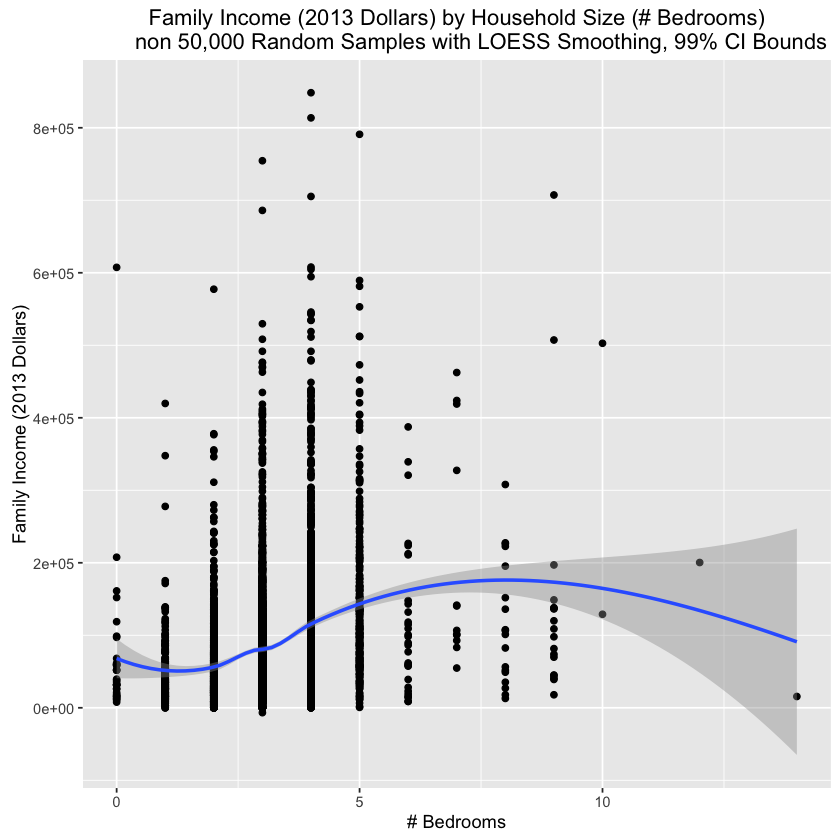

In [28]:
# take random sample to allow for reasonable timing of LOESS smoothing
# assign row index
final.dt <- final.dt[,index := seq.int(nrow(final.dt))]

# Randomly select 50 thou rows from index, seed @ 1000
samp_size <- 10000
set.seed(1000)
samp <- as.data.table(sample(nrow(final.dt), samp_size, replace = FALSE))
samp <- rename(samp,c('V1'='index'))

# exclude all non-selected rows via leftwise merge with vector of 
# randomly sampled index numbers
final.dt.new <- merge(samp,final.dt,all.x=TRUE, by='index')


########
# Loess plotting with 99% CI
sanity_plot <- 
ggplot() + 
	geom_point(data=final.dt.new,aes(x=BDSP, y=FINCP_adj)) +
		ggtitle("Family Income (2013 Dollars) by Household Size (# Bedrooms)\
        non 50,000 Random Samples with LOESS Smoothing, 99% CI Bounds") +
		xlab('# Bedrooms') +
		ylab('Family Income (2013 Dollars)') +
	geom_smooth(data=final.dt.new,stat = "smooth", method = "loess", 
        formula = y ~ x, se = TRUE, fullrange = T, level = 0.99, na.rm=F, 
                aes(x=BDSP,y=FINCP_adj))

suppressWarnings(print(sanity_plot))


As shown in the above plot, family income more or less increases with the number of bedrooms, which passes that standard (capitalist American) logic test. 

## biglm's Big Analysis

Now onto the assignment's final test: an analysis of the relationship between adjusted family income ('FINCP_adj') and number of bedrooms in the family home ('BDSP') while controlling for the number of vehicles owned by a family ('VEH'). I chose to do this using 'biglm'... again, because it was commanded by the assignemnt. However, biglm offers significant speed increases over standard lm methods in R when working with Big Data, so it was fun to learn about.

In [29]:
model <- biglm( FINCP_adj ~ BDSP + VEH , data = final.dt)
summary(model)
paste("R-squared:",summary(model)$rsq)

Large data regression model: biglm(FINCP_adj ~ BDSP + VEH, data = final.dt)
Sample size =  559896 
                 Coef      (95%      CI)       SE p
(Intercept) -3208.444 -3931.249 -2485.64 361.4023 0
BDSP        19199.932 18986.229 19413.63 106.8512 0
VEH         14837.111 14617.969 15056.25 109.5712 0

[1] "R-squared: 0.111942573796049"


From this, we see that, controlling for the number of vehicles owned, the average income of an American family is likely to be higher by approximately 19,199.93 (USD - 2013) for every additional bedroom in their home. Likewise, controllnig for the number of bedrooms in an American family's home, their income is likely to be 14,837.11 (USD - 2013) higher for every vehicle they own. This over a baseline net income of -3,208.44 (USD - 2013) for an American family that does not own a car or a house with bedrooms in it-- it should be noted, that intercetp coeffients such as this one are not always sensical, and so should be taken with a grain of salt. It should als be noted that the sampling strategy of the survey from which these data come allow us to make generalizations across the entire American population between 2009-2013.

And, just to confirm that the 1% subsample employed in the sanity-check plotting was a good approximation, I performed the same biglm analysis using the 1% subsample. The 95% CI of the coefficients produced during this analysis overlapped with those of each of the coefficients for the full 1 million row analysis, suggesting no statistical difference, and mean coefficient values for BDSP and VEH were of similar sizes and of the same signs (+). Good news!

In [30]:
model.new <- biglm( FINCP_adj ~ BDSP + VEH , data = final.dt.new)
summary(model.new)
paste("R-squared:",summary(model.new)$rsq)

Large data regression model: biglm(FINCP_adj ~ BDSP + VEH, data = final.dt.new)
Sample size =  5613 
                  Coef      (95%       CI)        SE      p
(Intercept)   476.3918 -6212.556  7165.339 3344.4737 0.8867
BDSP        17998.4024 16018.615 19978.190  989.8939 0.0000
VEH         14205.0653 12176.157 16233.974 1014.4542 0.0000

[1] "R-squared: 0.11581528181224"


  Interestingly, the sanity-check plot shows income decreasing with bedroom size after a certain number of bedrooms is reached. This may be an artifact of small sample size at the high end of bedroom # or perhaps the result of my random sample approach excluding high outliers, but it may also be related to the fact that wealthier families have greater access to debt capital and are more heavily involved in investing. These wealthy families may have net negative incomes in some years that are, in the long run, outweighed by massive gains in other years. Such folks could be living in mansions -- with many bedrooms-- despite an annual net income that is below average, especially in economic downturn years like 2009. A future analysis controlling for year of data collection or, perhaps, certain local or global economic indicators may help elucidate any such connection.

# Conclusion
This project was ultimately a very informative process. Still, I am not convinced that my readLines function was optimal as the literature I've read leading up to this report has lead me to believe that it should be faster than both the scan and read.csv approachs. My future work will explore ways to speed this up. Nonetheless, I now feel much more confident in my ability to read in large data files and perform expdited practical analyses like linear regression with big data. I especially look forward to employing virtual-memory read-in techniques like ff in my own work with big air pollution data.